In [1]:
#refference: https://blog.csdn.net/siyuelinruoan/article/details/104580690?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522161976320816780274180211%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=161976320816780274180211&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-3-104580690.pc_search_result_no_baidu_js&utm_term=garch%E6%A8%A1%E5%9E%8B+python

In [2]:
#pip install pandas-datareader

In [3]:
#pip install arch

In [4]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web##获取网页数据
import numpy as np

import statsmodels.formula.api as smf##回归模型
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from pmdarima import auto_arima
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test

import matplotlib.pyplot as plt 
import matplotlib as mpl
%matplotlib inline
p = print

p('Machine:{} {}\n'.format(os.uname().sysname,os.uname().machine))
p(sys.version)

Machine:Darwin x86_64

3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


In [5]:
#获取微软近十年股价数据并计算对数收益率

In [6]:
start = '2010-01-01'
end = '2020-04-28'

data = pd.DataFrame(web.get_data_yahoo('MSFT', start=start, end=end)['Adj Close'])

Irets = np.log(data/data.shift(1)).dropna()

In [7]:
p(Irets)

            Adj Close
Date                 
2010-01-04   0.015302
2010-01-05   0.000323
2010-01-06  -0.006156
2010-01-07  -0.010454
2010-01-08   0.006873
...               ...
2020-04-22   0.033401
2020-04-23  -0.012176
2020-04-24   0.018095
2020-04-27  -0.002869
2020-04-28  -0.024663

[2597 rows x 1 columns]


In [8]:
#平稳性检验

p-value:  2.0753437003906044e-30


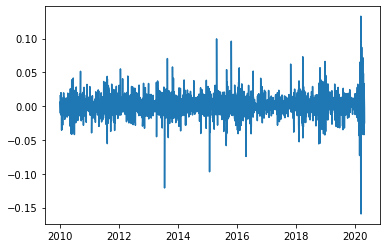

In [9]:
plt.plot(Irets)
plt.savefig('log_return.jpg')
t = sm.tsa.stattools.adfuller(Irets)  # ADF检验
print("p-value: ", t[1])

In [10]:
#p-value 小于显著值，因此序列是平稳的

In [11]:
Irets_diff = Irets.diff()

In [12]:
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):#定义局部样式
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)#自相关系数ACF图
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)#偏相关系数PACF图
        sm.qqplot(y, line='s', ax=qq_ax)#QQ图检验是否是正太分布
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

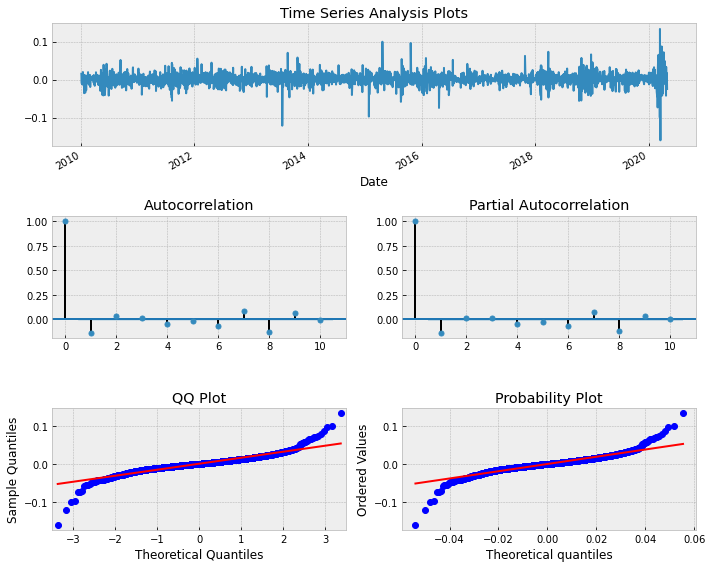

In [13]:
tsplot(Irets['Adj Close'],lags=10)
plt.savefig('log_ret时间序列分析.jpg')

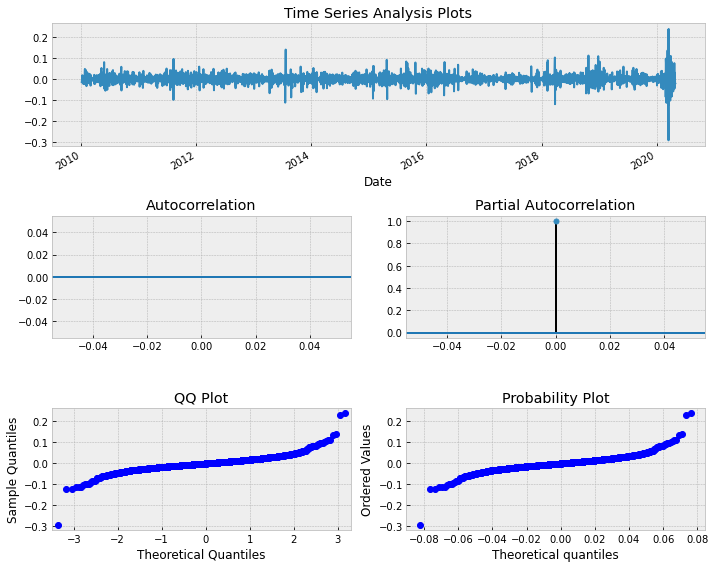

In [14]:
tsplot(Irets_diff['Adj Close'],lags=10)
plt.savefig('log_ret一阶导时间序列分析.jpg')

In [15]:
#from above plots we can conclude that Irets is meaningful, but diff_Irets is meaningless.

In [16]:
#进行L-Jungbox检验，输出p值序列：

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


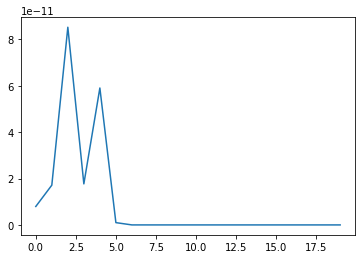

In [17]:
plt.plot(lb_test(Irets['Adj Close'],lags=20,boxpierce=False)[1])
plt.savefig('log_ret L-Jungbox检验.jpg')

In [18]:
#accept Irets: 当lags小于5时，Irets 序列具有显著的自相关性。

In [19]:
train = Irets['2010-01-01':'2020-12-31']
test = Irets['2021-01-01':'2021-04-28']

In [20]:
#利用ARMA(p,q)模型对股票价格进行预测

In [21]:
pip install pmdarima

You should consider upgrading via the '/Users/tao/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [22]:
model_x = auto_arima(Irets, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, seasonal=True, d=0, D=1,
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-14214.348, Time=1.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-14170.722, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-14215.914, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-14213.606, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-14166.802, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-14214.504, Time=0.89 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-14198.732, Time=1.31 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-14210.169, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 4.815 seconds


In [23]:
'''auto_arima(y, exogenous=None,
start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=10, m=1, seasonal=True, stationary=False, information_criterion=‘aic’, alpha=0.05, test=‘kpss’, seasonal_test=‘ch’, stepwise=True, n_jobs=1, start_params=None, trend=‘c’, method=None, transparams=True, solver=‘lbfgs’, maxiter=50, disp=0, callback=None, offset_test_args=None, seasonal_test_args=None, suppress_warnings=False, error_action=‘warn’, trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring=‘mse’, scoring_args=None, **fit_args)

y : 要拟合的时间序列，需要是一维的浮点型数组。不能包含‘np.nan’ 或者‘np.inf’；

exogenous : 可以在给定时间序列数据之外，给定额外的特征来帮助预测，需要注意的是，对于预测未来的时序数据的时候，也要提供未来的特征数据。

start_p : int, 默认2，算法自动选择p时的下界。

d : int, 默认None,非周期的差分阶数，如果是None，则自动选择，此时，运行时间会显著增加。

start_q : int, 默认2，算法自动选择q时的下界。

max_p : int, 默认5，算法自动选择p时的上界，必须≥start_p。

max_d : int, 默认2，算法自动选择d（非周期差分阶数）时的上界，必须≥d。

max_q : int, 默认5，算法自动选择q时的上界，必须≥start_q。

start_P : int,默认1，周期模型自动选择P时的下界。

D : int,默认None，周期差分的阶数，如果是None，则自动选择。

start_Q : int, 默认1，周期模型自动选择Q时的下界。

max_P : int,默认2，周期模型自动选择P时的上界。

max_D : int, 默认1，周期差分阶数的最大值，必须≥D。

max_Q : int,默认2，周期模型自动选择Q时的上界。

max_order : int,默认10，如果p+q≥max_order，该组合对应的模型将不会被拟合。

m : int, 默认1，周期数，例如季度数据m=4,月度数据m=12；如果m=1,则seasonal会被设置为False。

seasonal : bool, 默认True，是否进行周期ARIMA拟合。需要注意的是，如果seasonal=True同时m=1,seasonal会被设置为False。

stationary : bool, 默认False，标志该序列是否是平稳序列。

information_criterion : str, 默认’aic’，模型评价指标，‘aic’, ‘bic’, ‘hqic’,'oob’之一。

alpha : float,默认0.05，test的显著性水平。

test : str, 默认’kpss’，单位根检验的类型，当非平稳且d=None才会进行检验。

seasonal_test : str, 默认’ch’，周期单位根检验方法的标志。

stepwise : bool,默认True，如果为True，模型搜寻范围扩大，耗时显著增加。

n_jobs : int,默认1，并行拟合模型的数目，如果为-1，则尽可能多的并行。

start_params : array-like, 默认None，ARMA(p,q)的起始参数。

transparams : bool,默认True，如果为True，则进行变换确保平稳性，如果为False，不检验平稳性和可逆性。

method : str, 似然函数的类型，{‘css-mle’,‘mle’,‘css’}之一。

trend : str or iterable, 多项式趋势的多项式的系数。
'''

"auto_arima(y, exogenous=None,\nstart_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=10, m=1, seasonal=True, stationary=False, information_criterion=‘aic’, alpha=0.05, test=‘kpss’, seasonal_test=‘ch’, stepwise=True, n_jobs=1, start_params=None, trend=‘c’, method=None, transparams=True, solver=‘lbfgs’, maxiter=50, disp=0, callback=None, offset_test_args=None, seasonal_test_args=None, suppress_warnings=False, error_action=‘warn’, trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring=‘mse’, scoring_args=None, **fit_args)\n\ny : 要拟合的时间序列，需要是一维的浮点型数组。不能包含‘np.nan’ 或者‘np.inf’；\n\nexogenous : 可以在给定时间序列数据之外，给定额外的特征来帮助预测，需要注意的是，对于预测未来的时序数据的时候，也要提供未来的特征数据。\n\nstart_p : int, 默认2，算法自动选择p时的下界。\n\nd : int, 默认None,非周期的差分阶数，如果是None，则自动选择，此时，运行时间会显著增加。\n\nstart_q : int, 默认2，算法自动选择q时的下界。\n\nmax_p : int, 默认5，算法自动选择p时的上界，必须≥start_p。\n\nmax_d : int, 默认2，算法自动选择d（非周期差分阶数）时的上界，必须≥d。\

In [24]:
#According to the result of auro_arima function, we use AR(1) model to predict.

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<Figure size 864x576 with 0 Axes>

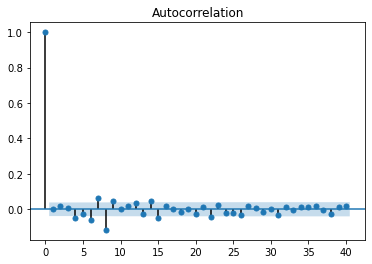

<Figure size 432x288 with 0 Axes>

In [25]:
model = sm.tsa.ARIMA(train, order=(1, 0, 0))
results = model.fit()
resid = results.resid #赋值
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40)
plt.show()
plt.savefig('模型残余值acf.jpg')

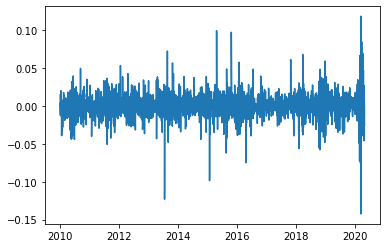

In [26]:
plt.plot(resid)

In [27]:
#the correlation of residuals is not zero, and the residuals are not stable. Her, we use GARCH model to deal with that.

In [28]:
#从自相关图中可见，在lag大于10以后数据大都落于置信区间内，因此使用garch(9,9)模型

In [29]:
garch = arch_model(resid, mean = 'constant',vol='Garch',p=9,q=9,o=0)
arch_fitted=garch.fit()
arch_fitted

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000245. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     22,   Neg. LLF: 886048208.1946559
Iteration:      2,   Func. Count:     50,   Neg. LLF: 2401.0146427598434
Iteration:      3,   Func. Count:     76,   Neg. LLF: 3374858392.2457256
Iteration:      4,   Func. Count:    104,   Neg. LLF: -1481.2274785182071
Iteration:      5,   Func. Count:    129,   Neg. LLF: 25121.182181852982
Iteration:      6,   Func. Count:    156,   Neg. LLF: 59489277.97748624
Iteration:      7,   Func. Count:    184,   Neg. LLF: 8389.741420063589
Iteration:      8,   Func. Count:    211,   Neg. LLF: 317401.83436898515
Iteration:      9,   Func. Count:    239,   Neg. LLF: 515053.52624470205
Iteration:     10,   Func. Count:    267,   Neg. LLF: 3314.851990717487
Iteration:     11,   Func. Count:    294,   Neg. LLF: 41505213.53975319
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7307.984804393142
            Iterations: 14
            Function evaluations: 303
            Gradient evalua

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7307.98
Distribution:                  Normal   AIC:                          -14576.0
Method:            Maximum Likelihood   BIC:                          -14458.7
                                        No. Observations:                 2597
Date:                Fri, May 07 2021   Df Residuals:                     2596
Time:                        10:20:58   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.5376e-04  5.537e-04      0.278      0.781 